<a href="https://colab.research.google.com/github/pra9raj/survival-prediction/blob/main/Ensembling_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an intro to Stacking Techinque ,a type of ensemle.the dataset used in this notebook is from Titanic Datset.

In [ ]:
# Loading in our Libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# import warnings
# warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

#Feature Exploring, Engineering and Cleaning

In [ ]:
# Load in train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Feature Engineering

In [ ]:
# This feature gives length of name
train['Name Length'] = train['Name'].apply(len)
test['Name Length'] = test['Name'].apply(len)

In [ ]:
# This feature tells if a person has a cabin or not
train['Has Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [ ]:
full_data = [train,test]

# Create a new feature FamilySize from Parch and SibSp feature
for dataset in full_data:
  dataset['FamilySize'] = dataset['Parch'] + dataset ['SibSp'] + 1

In [ ]:
# Create a new feature isalone from FamilySize
for dataset in full_data:
  dataset['Is Alone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, ['Is Alone']] = 1

In [ ]:
# Remove all NULLS in embarked column
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [ ]:
# Remove all NULLS in the Fare column
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Create a new feature CategoricalFare
train['CategorialFare'] = pd.qcut(train['Fare'], 4)

In [ ]:
# Create a new feature CategorialAge
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_randomlist = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_randomlist
  dataset['Age'] = dataset['Age'].astype(int)
train['CategorialAge'] = pd.qcut(train['Age'], 5)

<ipython-input-9-96f0c99bb257>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-96f0c99bb257>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Define a function to extract Titles from Names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [ ]:
for dataset in full_data:
  # Mapping sex
  dataset['Sex'] = dataset['Sex'].map({'female': 0 , 'male' : 1}).astype(int)

  # Mapping titles
  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  # Mapping Fare
  dataset.loc[ dataset['Fare'] > 7.91 , 'Fare']                                   = 0
  dataset.loc[(dataset['Fare'] > 7.91)   & (dataset['Fare'] <= 14.454), 'Fare']   = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31)    , 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31   , 'Fare']                                   = 3

  dataset['Fare'] = dataset['Fare'].astype(int)

  # Mapping Age
  dataset.loc[ dataset['Age'] <= 16, 'Age'] 					                = 0
  dataset.loc[(dataset['Age'] > 16)  & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32)  & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48)  & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64,  'Age']                           = 4

Feature Selection

In [ ]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategorialAge', 'CategorialFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name Length,Has Cabin,FamilySize,Is Alone,Title
0,0,3,1,1,0,7,0,23,0,2,0,1
1,1,1,0,2,0,0,1,51,1,2,0,3
2,1,3,0,1,0,0,0,22,0,1,1,2
3,1,1,0,2,0,0,0,44,1,2,0,3
4,0,3,1,2,0,0,0,24,0,1,1,1


**Data Visualization**

Pearson Correlation Heatmap

<Axes: title={'center': 'Pearson Correlation of Features'}>

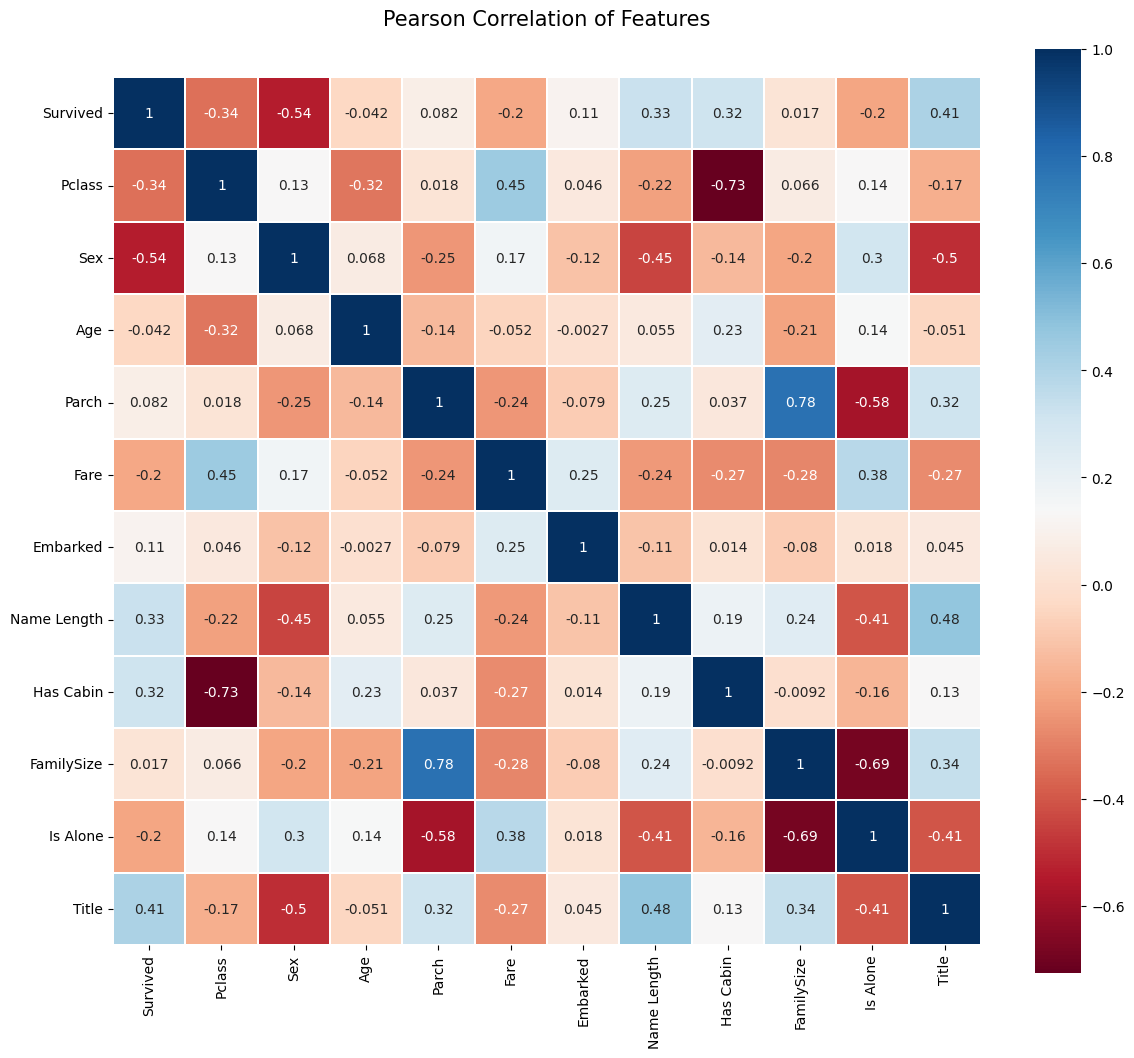

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

### Take away from the plots
Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another.This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information

PairPlots

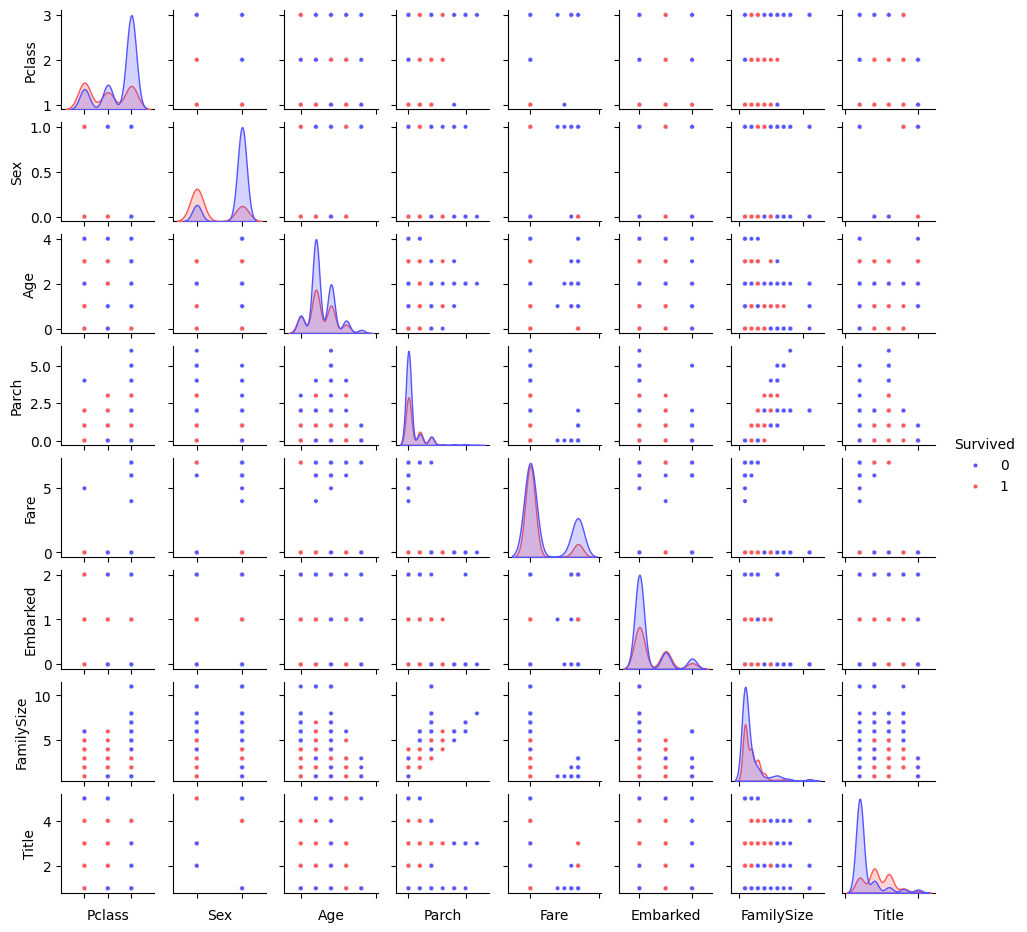

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',height = 1.2, diag_kind = 'kde',
                 diag_kws=dict(fill=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling and Stacking Models

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS,shuffle=True, random_state=SEED,)

# Class to extend the SkLearn Classifier
class SklearnHelper(object):
  def __init__(self, clf, seed=0, params=None):
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def fit(self,x, y):
    return self.clf.fit(x, y)

  def predict(self, x):
    return self.clf.predict(x)

  def feature_importances(self, x, y):
        return list(self.clf.feature_importances_)

we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker

### Out-Of-Fold Predictions

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
  oof_train = np.zeros((ntrain,))
  oof_test = np.zeros((ntest,))
  oof_test_skf = np.empty((NFOLDS, ntest))

  for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models¶

The five models we will be using are:
1.   Extra Trees classifier
2.   AdaBoost classifer
3.   Gradient Boosting classifer
4.   Support Vector Machine
5.   Random Forest classifier

In [ ]:
# putting in parameters for our classifiers
# Random Forest Parameters
rf_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'warm_start':True,
    # 'max_features':0.2,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':1
}

# Extra Tress Parameters
et_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'max_features':0.5,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':1
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 1
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier

In [ ]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

Creating numpy arrays out of our test and train datasets

In [ ]:
y_train = train['Survived'].ravel()
train = train .drop(['Survived'],axis = 1)
x_train = train.values
x_test = test.values

Output of first level predictions

In [ ]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finis

      Iter       Train Loss   Remaining Time 
         1           1.2253            1.49s
         2           1.1399            1.42s
         3           1.0710            1.40s
         4           1.0132            1.40s
         5           0.9648            1.38s
         6           0.9200            1.37s
         7           0.8834            1.36s
         8           0.8495            1.35s
         9           0.8227            1.34s
        10           0.7989            1.33s
        20           0.6551            1.14s
        30           0.5809            1.06s
        40           0.5272            1.01s
        50           0.4911            0.96s
        60           0.4665            0.92s
        70           0.4397            0.89s
        80           0.4152            0.87s
        90           0.3938            0.84s
       100           0.3711            0.85s
       200           0.2698            0.60s
       300           0.2101            0.39s
       40

Feature importances generated from all classifiers

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train,y_train)
gb_feature = gb.feature_importances(x_train,y_train)

Create a dataframe from the features extracted

In [ ]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'features' : cols,
    'Random Forest Feature Importance' : rf_feature,
    'Extra Tress Feature Importance' : et_feature,
    'Adaboost  Feature Importances' : ada_feature,
    'Gradient Boosting Feature Importances' : gb_feature
})
feature_dataframe

,features,Random Forest Feature Importance,Extra Tress Feature Importance,Adaboost Feature Importances,Gradient Boosting Feature Importances
0,Pclass,0.108042,0.152385,0.014,0.129690
1,Sex,0.218406,0.394851,0.010,0.207578
2,Age,0.035188,0.033349,0.022,0.052993
3,Parch,0.020964,0.016289,0.028,0.012625
4,Fare,0.015199,0.020110,0.106,0.027254
5,Embarked,0.028310,0.037045,0.020,0.030671
6,Name Length,0.133740,0.059816,0.650,0.198734
7,Has Cabin,0.052444,0.092186,0.012,0.044479
8,FamilySize,0.073265,0.051383,0.048,0.084357
9,Is Alone,0.014859,0.012757,0.006,0.008372


In [ ]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest Feature Importance'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest Feature Importance'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
fig.show(renderer="colab")

Do the same with all classfiers

Now let us create mean of all feature importance and store it in a new column in feature dataframe

In [ ]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.iloc[:,[1,2,3,4]].mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(5)

,features,Random Forest Feature Importance,Extra Tress Feature Importance,Adaboost Feature Importances,Gradient Boosting Feature Importances,mean
0,Pclass,0.108042,0.152385,0.014,0.129690,0.101029
1,Sex,0.218406,0.394851,0.010,0.207578,0.207709
2,Age,0.035188,0.033349,0.022,0.052993,0.035882
3,Parch,0.020964,0.016289,0.028,0.012625,0.019469
4,Fare,0.015199,0.020110,0.106,0.027254,0.042141


Plot the barplots using ploty barplots

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x=x,y= y,width = 0.5,marker=dict( color = feature_dataframe['mean'].values,
            colorscale='Portland',showscale=True,reversescale = False),
            opacity=0.6 )]

layout= go.Layout(autosize= True,title= 'Barplots of Mean Feature Importance',hovermode= 'closest',
yaxis=dict(title= 'Feature Importance',ticklen= 5,gridwidth= 2),
    showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')
fig.show(renderer="colab")

# Second Level outputs From First Level Predictions

After obtaining output for our first level predictions we can build a new set of features to be used as new features as training data for the next classfiers

In [ ]:
base_predictions_train  = pd.DataFrame({
    'RandomForest':rf_oof_train.ravel(),
    'ExtraTrees':et_oof_train.ravel(),
    'AdaBoost':ada_oof_train.ravel(),
    'GradientBoosting':gb_oof_train.ravel()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoosting
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


Correlation heatmap of second level training set

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

Concatenating and joining both the first level train and test predictions as x_train and x_test we cannow fit a second level training model

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

# Second Level Learning Model Via XGBoost
We call an XGBClassifier and fit it to the first level train and target data and use the learned model to predict the test data as follows:

In [ ]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
# Generate Submission File
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)